[Forecasting: Principles and Practice](https://otexts.com/fpp2/)

## Agenda

[0.0 Loading Data](#0.0-Loading-Data)<br>

[1.0 Decomposition](#1.0-Decomposition)<br>

[2.0 Stationarity](#2.0-Stationarity)<br>

[3.0 Autocorrelation](#3.0-Autocorrelation)<br>

[4.0 Partial Autocorrelation](#4.0-Partial-Autocorrelation)<br>


[5.0 ARIMA](#5.0-ARIMA)<br>
&nbsp;[5.1 Train Test Split](#5.1-Train-Test-Split)<br>
&nbsp;[5.2 Finding Best P, D, Q](#5.2-Finding-Best-P,-D,-Q)<br>

[6.0 Modeling](#6.0-Modeling)<br>
&nbsp;[6.1 Modeling by Best pdq](#6.1-Modeling-by-Best-pdq)<br>

[7.0 Final Model](#7.0-Final-Model)<br>

[8.0 Results on Total Olist Sales](#8.0-Results-on-Total-Olist-Sales)

[9.0 Deploy Model to Production](#9.0-Deploy-Model-to-Production)<br>
&nbsp;[9.1 Save Model](#9.1-Save-Model)<br>
&nbsp;[9.2 OlistSales Class](#9.2-OlistSales-Class)<br>

In [238]:
from notebook_utils.utils import *
from notebook_utils.ml_utils import *

import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR

import itertools
import warnings

from sklearn.metrics import mean_squared_error

import joblib

In [2]:
directory = Directory("1.5-pr-regional-sales-prediction")

In [3]:
def index_to_date(data_frame):
    data_frame.index = pd.to_datetime(data_frame.index)
    data_frame.index.name = 'date'
    return data_frame

def fig(x=15, y=5):
    plt.rcParams['figure.figsize'] = (x, y)
    
def train_test_split(df):
    training_data = df.loc['2017-01-31':'2018-03-31', 'revenue']
    testing_data = df.loc['2018-04-30':'2018-06-30', 'revenue']
    production_data = df.loc['2018-07-31':, 'revenue']
    final_training_data = df.loc['2017-01-31':'2018-06-30', 'revenue']
    
    return training_data, testing_data, production_data, final_training_data

def train_test(training_data, testing_data, p, d, q, return_model=False, forecast=3, evaluate=True,
               evaluate_in="2nd Quarter of 2018"):
    model = ARIMA(training_data.values, order=(p, d, q)).fit()
    if evaluate:
        evaluation(testing_data, model.forecast(forecast), evaluate_in)
    if return_model: return model

def find_best_pdq(training_data, testing_data,
                  p_range=range(0, 8), d_range=range(0, 2), q_range=range(0, 8),
                  max_combinations=128, sort_values_by='rmse'):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        p, d, q = p_range, d_range, q_range
        pdq_combination = list(itertools.product(p,d,q)) # 128 combinations
        rmse = []
        mae = []
        mape = []
        pdq_as_index = []

        for pdq in pdq_combination[:max_combinations]:
            try:
                model = ARIMA(training_data.values, order=(pdq)).fit()
                predictions = model.forecast(len(testing_data))
                rmse_value = np.sqrt(mean_squared_error(testing_data, predictions))
                mae_value = mean_absolute_error(testing_data, predictions)
                mape_value = mean_absolute_percentage_error(testing_data, predictions)
                pdq_as_index.append(pdq)
                rmse.append(rmse_value)
                mae.append(mae_value)
                mape.append(mape_value)
            except:
                continue
                                
    return pd.DataFrame(data={'rmse': rmse, 'mae':mae, 'mape':mape},
                        index=pd.Series(pdq_as_index, name='pdq')).sort_values(sort_values_by)



## 0.0 Loading Data

In [4]:
data_frame_to_process = pd.read_pickle(os.path.join(os.path.join(directory.DATA_DIR, "sales_forecast_data"),
                                                    "ml_data_to_preprocess.pkl"))
data_frame_to_process['revenue'] = data_frame_to_process['freight_value'] + data_frame_to_process['price']
df = data_frame_to_process.groupby([data_frame_to_process['region'],
                                    data_frame_to_process['order_purchase_timestamp'].dt.date])[['revenue']].sum()
df.head()

revenue
region  order_purchase_timestamp         
midwest 2017-01-12                 366.26
        2017-01-13                 149.62
        2017-01-14                 217.90
        2017-01-15                  54.95
        2017-01-16                 327.40

In [5]:
# df.index.get_level_values('region').unique()

In [6]:
midwest = index_to_date(df.loc['midwest']).resample("M").sum()
north = index_to_date(df.loc['north']).resample("M").sum()
northeast = index_to_date(df.loc['northeast']).resample("M").sum()
south = index_to_date(df.loc['south']).resample("M").sum()
southeast = index_to_date(df.loc['southeast']).resample("M").sum()

regions = {
    'midwest':midwest,
    'north':north,
    'northeast':northeast,
    'south':south,
    'southeast':southeast
}

## 1.0 Decomposition

In [7]:
fig(15, 9)

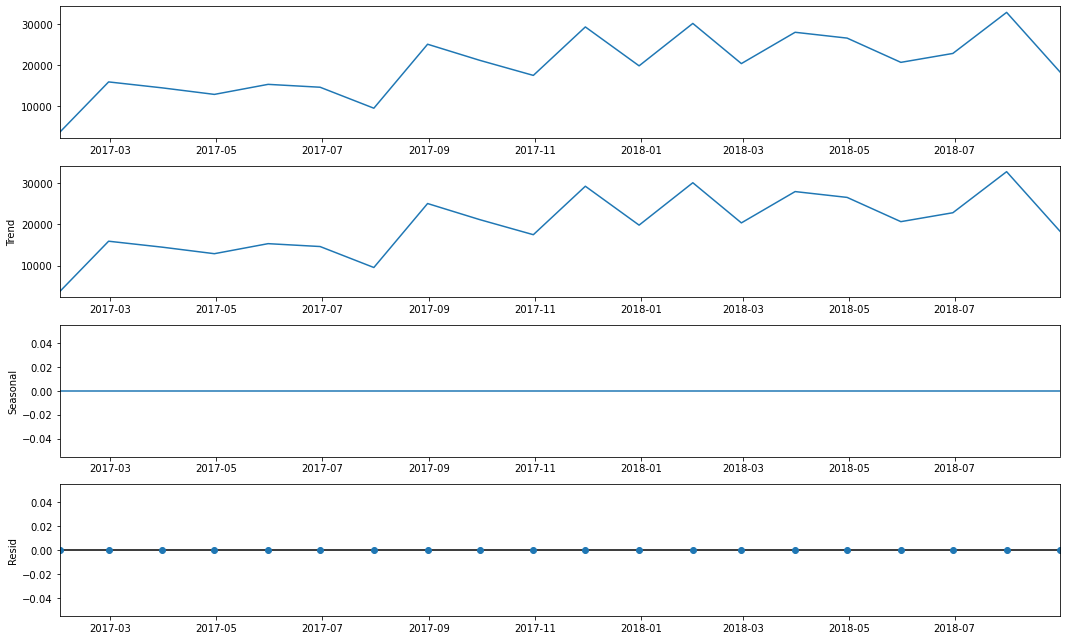

In [8]:
# Regions are pretty similar
seasonal_decompose(regions['north'], period=1).plot()
plt.show()

## 2.0 Stationarity

In [9]:
for region in regions.keys():
    result = adfuller(regions[region])
    print("    ",region)
    print('p-value: %f' % result[1])
    print('Stationary:', (result[1] <= 0.05))
    print()

     midwest
p-value: 0.234520
Stationary: False

     north
p-value: 0.042303
Stationary: True

     northeast
p-value: 0.254943
Stationary: False

     south
p-value: 0.259500
Stationary: False

     southeast
p-value: 0.241518
Stationary: False



## 3.0 Autocorrelation

        'midwest': 2,
        'north': 0,
        'northeast': 1,
        'south': 2,
        'southeast': 2

In [10]:
fig(15, 4)

                                                        MIDWEST:


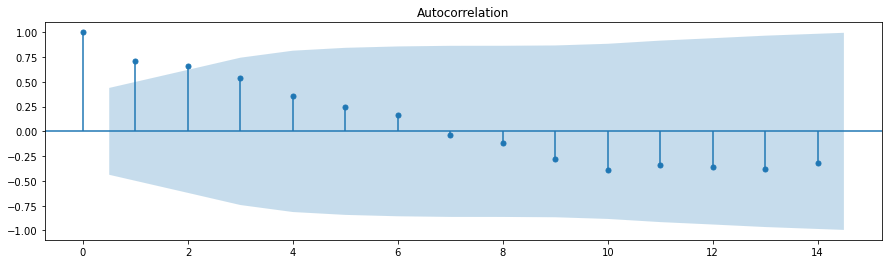

                                                        NORTH:


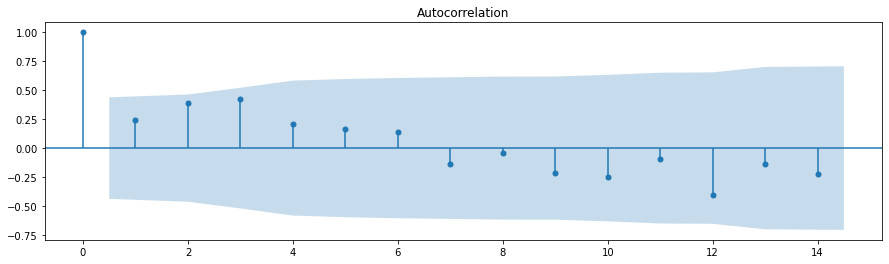

                                                        NORTHEAST:


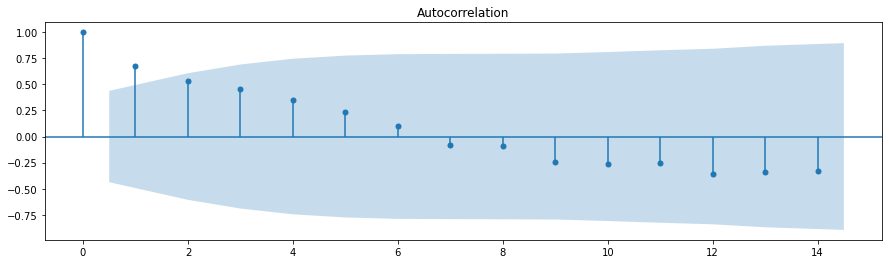

                                                        SOUTH:


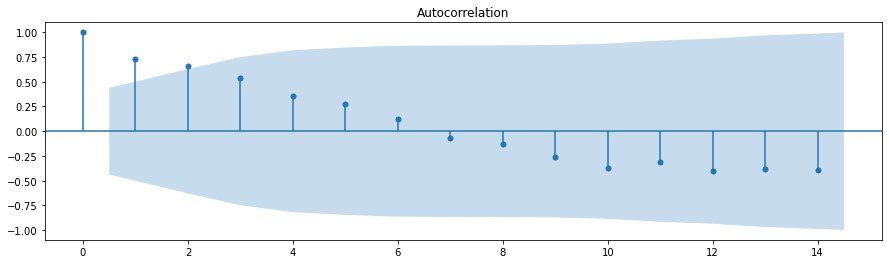

                                                        SOUTHEAST:


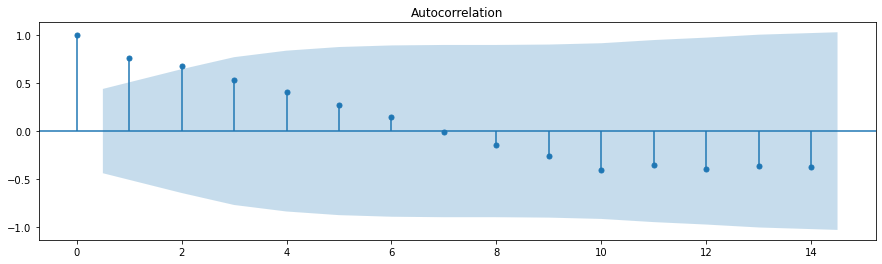

In [11]:
for region in regions.keys():
    print(" "*55, region.upper() + ":")
    plot_acf(regions[region], alpha = 0.05);
    plt.show()

## 4.0 Partial Autocorrelation

        'midwest': 1,
        'north': 0,
        'northeast': 1,
        'south': 1,
        'southeast': 1 

                                                        MIDWEST:


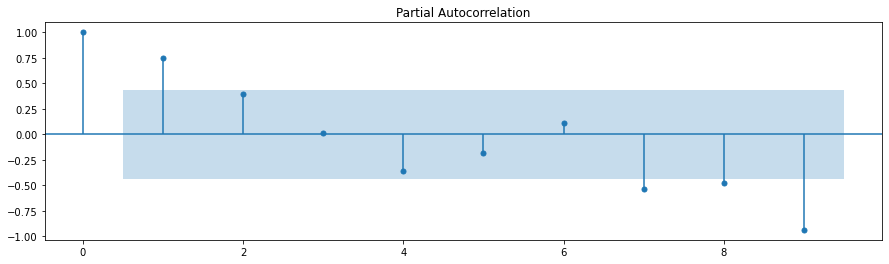

                                                        NORTH:


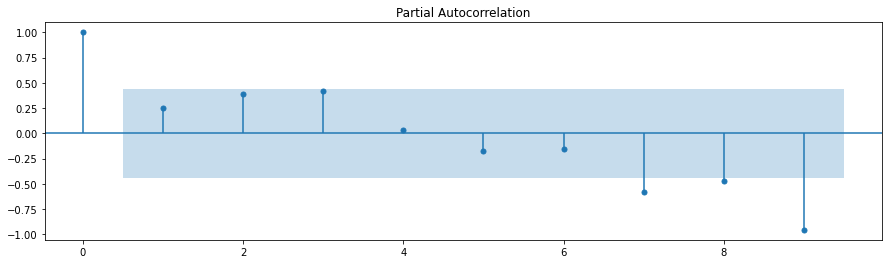

                                                        NORTHEAST:


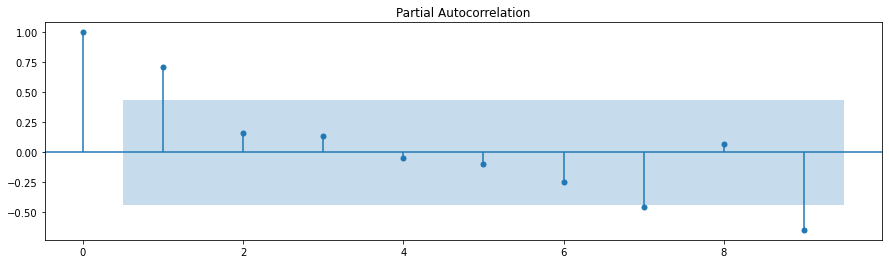

                                                        SOUTH:


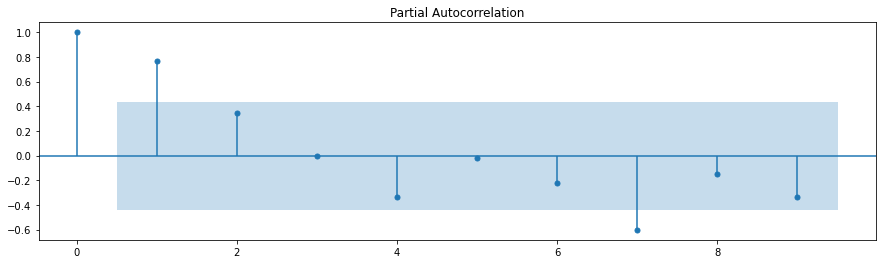

                                                        SOUTHEAST:


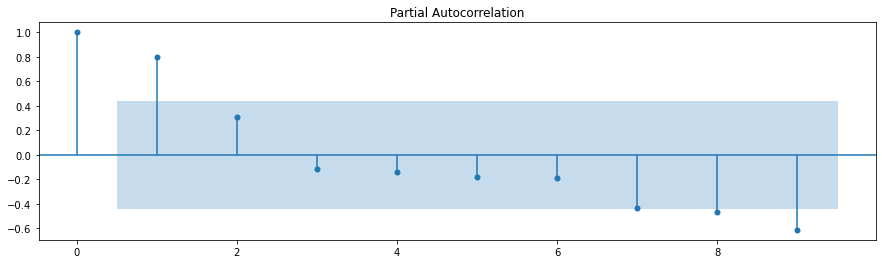

In [12]:
for region in regions.keys():
    print(" "*55, region.upper() + ":")
    plot_pacf(regions[region], lags=9, alpha = 0.05);
    plt.show()

## 5.0 ARIMA

### 5.1 Train Test Split

In [13]:
midwest_train,   midwest_test,   midwest_production,   midwest_final_training   = train_test_split(midwest)
north_train,     north_test,     north_production,     north_final_training     = train_test_split(north)
northeast_train, northeast_test, northeast_production, northeast_final_training = train_test_split(northeast)
south_train,     south_test,     south_production,     south_final_training     = train_test_split(south)
southeast_train, southeast_test, southeast_production, southeast_final_training = train_test_split(southeast)

### 5.2 Finding Best P, D, Q

In [14]:
midwest_pdq_parameters   = find_best_pdq( midwest_train,   midwest_test, sort_values_by='mape')
north_pdq_parameters     = find_best_pdq( north_train,     north_test, sort_values_by='mape')
northeast_pdq_parameters = find_best_pdq( northeast_train, northeast_test, sort_values_by='mape')
south_pdq_parameters     = find_best_pdq( south_train,     south_test, sort_values_by='mape')
southeast_pdq_parameters = find_best_pdq( southeast_train, southeast_test, sort_values_by='mape')

## 6.0 Modeling
        
        Autocorrelation
            'midwest': 2,
            'north': 0,
            'northeast': 1,
            'south': 2,
            'southeast': 2
       
        Partial Autocorrelation:
            'midwest': 1,
            'north': 0,
            'northeast': 1,
            'south': 1,
            'southeast': 1 
            
        north is stationary else is not

In [15]:
print("midwest")
train_test(midwest_train, midwest_test, p=2, d=1, q=1)
print("\nnorth")
train_test(north_train, north_test, p=0, d=0, q=0)
print("\nnortheast")
train_test(northeast_train, northeast_test, p=1, d=1, q=1)
print("\nsouth")
train_test(south_train, south_test, p=2, d=1, q=1)
print("\nsoutheast")
train_test(southeast_train, southeast_test, p=2, d=1, q=1)

midwest
2nd Quarter of 2018
On average, our predictions are 14.13% above or below the real value.
Which means an error of about R$ 9,556.43

north
2nd Quarter of 2018
On average, our predictions are 19.87% above or below the real value.
Which means an error of about R$ 4,841.40

northeast


C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2nd Quarter of 2018
On average, our predictions are 10.44% above or below the real value.
Which means an error of about R$ 11,211.44

south
2nd Quarter of 2018
On average, our predictions are 19.75% above or below the real value.
Which means an error of about R$ 30,398.81

southeast
2nd Quarter of 2018
On average, our predictions are 8.41% above or below the real value.
Which means an error of about R$ 56,411.25


C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


### 6.1 Modeling by Best pdq

In [16]:
display(midwest_pdq_parameters.head(10).T)
display(north_pdq_parameters.head(10).T)
display(northeast_pdq_parameters.head(10).T)
display(south_pdq_parameters.head(10).T)
display(southeast_pdq_parameters.head(10).T)

pdq,"(5, 1, 2)","(6, 1, 1)","(4, 1, 5)","(5, 1, 5)","(7, 1, 3)","(5, 1, 7)","(5, 1, 1)","(6, 1, 5)","(4, 1, 0)","(6, 1, 7)"
rmse,4096.852953,3600.393585,3533.543860,3486.924702,4981.851509,4005.608297,5718.217550,4891.256156,8663.276897,5422.434874
mae,3170.195391,3349.316530,3471.956246,3469.935128,3653.009744,3827.776130,4590.291370,4276.272329,5537.846817,4450.661465
mape,0.042685,0.048715,0.050968,0.051082,0.055828,0.058536,0.062105,0.067301,0.070456,0.071083


pdq,"(2, 0, 3)","(6, 0, 1)","(0, 0, 7)","(6, 0, 2)","(1, 0, 1)","(2, 0, 2)","(4, 0, 1)","(5, 0, 5)","(2, 0, 6)","(6, 0, 0)"
rmse,2203.379237,2021.738099,2650.116702,2322.619161,2213.822416,2150.524738,2134.497553,2378.336813,2759.846369,2646.775215
mae,1382.210620,1646.841417,1953.857766,1875.333531,1868.970673,2000.919642,2040.741582,2059.270286,2187.147365,2161.483273
mape,0.053006,0.068226,0.077630,0.077812,0.079408,0.084633,0.086697,0.087030,0.089878,0.090350


pdq,"(7, 1, 1)","(6, 0, 5)","(1, 0, 5)","(2, 0, 0)","(5, 0, 5)","(1, 0, 1)","(1, 0, 7)","(3, 0, 7)","(4, 0, 5)","(0, 0, 7)"
rmse,9596.233876,10520.201511,10306.158106,12748.672258,11841.855190,12907.873459,12365.050726,12019.801473,12759.487717,13088.295662
mae,6570.765966,7969.658814,8813.436155,8535.616486,8892.619343,9445.922800,9766.948015,9860.302694,9831.516352,10702.178106
mape,0.060286,0.071704,0.077804,0.078562,0.080513,0.085711,0.087699,0.088050,0.088565,0.089797


pdq,"(1, 0, 5)","(2, 0, 1)","(3, 0, 1)","(1, 0, 1)","(3, 0, 0)","(2, 0, 0)","(7, 0, 5)","(4, 0, 5)","(6, 0, 5)","(5, 0, 5)"
rmse,20273.118283,21090.168963,20994.695813,19559.146267,20967.224563,21066.180027,21614.779884,23007.546407,21400.236209,21635.777171
mae,14029.599325,14368.372295,14450.018492,14449.711814,14591.554100,14703.963461,14958.432864,15156.705317,15040.545455,15072.062825
mape,0.079405,0.080978,0.081838,0.082124,0.082588,0.083384,0.083410,0.084127,0.084134,0.084164


pdq,"(1, 1, 6)","(7, 0, 3)","(4, 1, 1)","(6, 1, 3)","(5, 1, 3)","(7, 1, 3)","(7, 1, 2)","(2, 1, 3)","(0, 1, 0)","(1, 1, 3)"
rmse,39147.533518,41216.828996,54919.887115,44763.138330,44763.142118,44763.146744,44763.141322,44763.131546,44763.122546,51613.360875
mae,32400.043410,38778.597688,40691.938787,38962.929353,38962.935553,38962.933986,38962.936185,38962.941378,38962.956667,40781.319390
mape,0.045244,0.053788,0.055556,0.055782,0.055782,0.055782,0.055782,0.055782,0.055782,0.055892


In [17]:
print("midwest")
train_test(midwest_train, midwest_test, p=5, d=1, q=1) 
print("\nnorth")
train_test(north_train, north_test, p=6, d=0, q=1)
print("\nnortheast")
train_test(northeast_train, northeast_test, p=2, d=0, q=0)
print("\nsouth")
train_test(south_train, south_test, p=1, d=0, q=5)
print("\nsoutheast")
train_test(southeast_train, southeast_test, p=0, d=1, q=0)

midwest
2nd Quarter of 2018
On average, our predictions are 6.21% above or below the real value.
Which means an error of about R$ 4,590.29

north
2nd Quarter of 2018
On average, our predictions are 6.82% above or below the real value.
Which means an error of about R$ 1,646.84

northeast
2nd Quarter of 2018
On average, our predictions are 7.86% above or below the real value.
Which means an error of about R$ 8,535.62

south
2nd Quarter of 2018
On average, our predictions are 7.94% above or below the real value.
Which means an error of about R$ 14,029.60

southeast
2nd Quarter of 2018
On average, our predictions are 5.58% above or below the real value.
Which means an error of about R$ 38,962.96


C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


## 7.0 Final Model

In [18]:
# ??train_test

In [19]:
print("midwest")
train_test(midwest_final_training, midwest_production, p=5, d=1, q=2, forecast=2, evaluate_in='3rd Quarter of 2018') 
print("\nnorth")
train_test(north_final_training, north_production, p=2, d=0, q=3, forecast=2, evaluate_in='3rd Quarter of 2018')
print("\nnortheast")
train_test(northeast_final_training, northeast_production, p=7, d=1, q=1, forecast=2, evaluate_in='3rd Quarter of 2018')
print("\nsouth")
train_test(south_final_training, south_production, p=1, d=0, q=6, forecast=2, evaluate_in='3rd Quarter of 2018')
print("\nsoutheast")
train_test(southeast_final_training, southeast_production, p=1, d=1, q=6, forecast=2, evaluate_in='3rd Quarter of 2018')

midwest


C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


3rd Quarter of 2018
On average, our predictions are 24.48% above or below the real value.
Which means an error of about R$ 13,663.55

north


C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3rd Quarter of 2018
On average, our predictions are 28.53% above or below the real value.
Which means an error of about R$ 7,562.00

northeast
3rd Quarter of 2018
On average, our predictions are 40.12% above or below the real value.
Which means an error of about R$ 42,181.79

south
3rd Quarter of 2018
On average, our predictions are 1.58% above or below the real value.
Which means an error of about R$ 2,195.12

southeast


C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


3rd Quarter of 2018
On average, our predictions are 10.31% above or below the real value.
Which means an error of about R$ 66,034.08


## 8.0 Results on Total Olist Sales

In [86]:
midwest_model = train_test(midwest_final_training, midwest_production, p=5, d=1, q=1, return_model=True, evaluate=False) 

north_model = train_test(north_final_training, north_production, p=6, d=0, q=1, return_model=True, evaluate=False)

northeast_model = train_test(northeast_final_training, northeast_production, p=2, d=0, q=0, return_model=True, evaluate=False)

south_model = train_test(south_final_training, south_production, p=1, d=0, q=6, return_model=True, evaluate=False)

southeast_model = train_test(southeast_final_training, southeast_production, p=1, d=1, q=6, return_model=True, evaluate=False)

C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [87]:
df_final_train = {
    'midwest':midwest_final_training,
    'north':north_final_training,
    'northeast':northeast_final_training,
    'south':south_final_training,
    'southeast':southeast_final_training
}

df_production = {
    'midwest':midwest_production,
    'north':north_production,
    'northeast':northeast_production,
    'south':south_production,
    'southeast':southeast_production    
}

data_final_train = pd.DataFrame(data=df_final_train)
data_production = pd.DataFrame(data=df_production)

preds = {
    'midwest':midwest_model.forecast(2),
    'north':north_model.forecast(2),
    'northeast':northeast_model.forecast(2),
    'south':south_model.forecast(2),
    'southeast':southeast_model.forecast(2)
}
predictions = pd.DataFrame(data=preds, index=data_production.index)

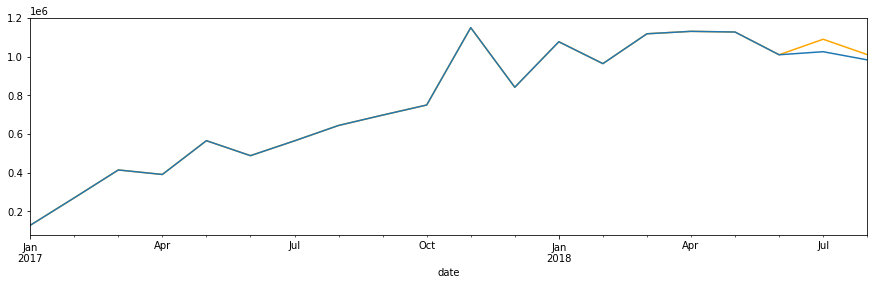

In [88]:
df_preds = pd.concat([data_final_train, predictions]).sum(axis=1)
original_df = pd.concat([data_final_train, data_production]).sum(axis=1)

df_preds.plot(color='orange')
original_df.plot();

In [89]:
evaluation(original_df.loc['2018-07-31':], df_preds.loc['2018-07-31':])

On average, our predictions are 4.54% above or below the real value.
Which means an error of about R$ 45,900.02


(45900.02, 4.536166562706876)

## 9.0 Deploy Model to Production

### 9.1 Save Model

#### midwest_model
north_model
northeast_model
south_model
southeast_model.forecast(3)

In [97]:
region_arima = {
    'midwest':midwest_model,
    'north':north_model,
    'northeast':northeast_model,
    'south':south_model,
    'southeast':southeast_model    
}

filename = 'olist_arima_models_by_region.joblib'
path = os.path.join(os.path.join(os.path.dirname(directory.THIS_DIR), "models"), filename)
# joblib.dump(region_arima, path)

In [111]:
arimas = joblib.load(path)
arimas

{'midwest': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x196794686a0>,
 'north': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x19679459be0>,
 'northeast': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x19679459ac0>,
 'south': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x196794156a0>,
 'southeast': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x1967bab23d0>}

### 9.2 OlistSales Class

In [233]:
def convert_region(region):
    pt_en_regions = {
        'centro oeste': 'midwest', 
        'norte': 'north', 
        'nordeste': 'northeast',
        'sul': 'south',
        'sudeste': 'southeast'
    }
    try: 
        return pt_en_regions[region]
    except:
        return region
    

class OlistSales:
    def __init__(self):
        self.arima = joblib.load(path)
        self.valid_regions = ['midwest', 'north', 'northeast', 'south', 'southeast',
                              'centro oeste', 'norte', 'nordeste', 'sul', 'sudeste',
                              'all', 'todas']
        
    def get_forecast(self, region='all'):
        region = region.strip(" ").lower()
        if region in ['all', 'todas', '']:
            return self.get_sales_forecast()
        if self.validate_region(region):
            return self.arima[convert_region(region)].forecast(3)
        else:
            raise ValueError(f"Invalid Region. Current Valid regions: {self.valid_regions}")
    
    def validate_region(self, region):
        if region in self.valid_regions:
            return True
        if not region:
            print("not: ", region)
            return True
        else: return False
        
    def get_sales_forecast(self):
        preds = {}
        for region in self.arima.keys():
            preds[region] = self.arima[region].forecast(3)        
        return pd.DataFrame(data=preds).sum(axis=1)

In [235]:
olist_sales = OlistSales()
try:
   olist_sales.get_forecast(str())
except Exception as e:
    print(e)